# Primer set


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions

In [50]:
# Abrimos y ajustamos los datos para leerlos
datos_pacientes = pd.read_csv("Datos.csv",sep = ";")
datos_pacientes["Marca de tiempo"] = pd.to_datetime(datos_pacientes["Marca de tiempo"])
datos_operaciones = pd.read_csv("Datos operaciones origen urgencias.csv")

datos_operaciones = datos_operaciones.iloc[:,:5]
datos_operaciones = datos_operaciones.drop(datos_operaciones.columns[3],axis = 1)

In [51]:
#Estas son las áreas que aparecen en el diagrama entregado
areas_mapa_profe = ["URG101_003","DIV101_603","DIV101_604","DIV101_703","DIV102_203","DIV103_107","DIV103_204",
"DIV104_602","OPR101_011","OPR101_033","OPR102_001","OPR102_003","End"]

In [52]:
# Lo primero que haremos será filtrar los datos para obtener el nodo "Outisde"
filtro_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))
datos_pacientes.loc[filtro_fuera,"Area"] = "Outside"

In [53]:
#Eliminamos las filas donde el valor actual y el anterior corresponden al nodo outside, dejamos el primero,
#marcando así la entrada del paciente al nodo outside, pero solo una vez 
filtro_doble_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))&((~datos_pacientes["Area"].shift(1).isin(areas_mapa_profe)))
datos_pacientes = datos_pacientes[~filtro_doble_fuera]


In [54]:
datos_pacientes["Hora derivacion"] = datos_pacientes["Marca de tiempo"].shift(-1)
datos_pacientes["Estadia"] = datos_pacientes["Hora derivacion"]  - datos_pacientes["Marca de tiempo"]
datos_pacientes["Estadia"] = datos_pacientes["Estadia"]/np.timedelta64(1,"h")
datos_pacientes["Siguiente Área"] = datos_pacientes["Area"].shift(-1)

In [55]:
import pylab as pl

In [56]:
plt.style.use('ggplot')

Probabilidad de transición desde la sala de urgencias (DIV101_703)
Outside       34.680135
End           23.456790
DIV103_204    11.111111
DIV104_602     7.182941
DIV101_604     6.060606
DIV101_603     5.162738
DIV103_107     5.050505
DIV102_203     4.040404
OPR102_003     3.030303
OPR101_033     0.112233
OPR102_001     0.112233
Name: Siguiente Área, dtype: float64


Text(0.5, 0, 'Horas')

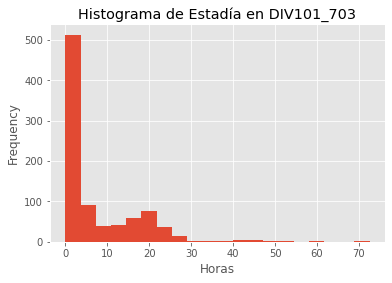

In [57]:
area = "DIV101_703"
derivacion_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Siguiente Área"]
print(f"Probabilidad de transición desde la sala de urgencias ({area})")
transiciones = (derivacion_urgencia.value_counts()/derivacion_urgencia.shape[0])*100
print(transiciones)
estadia_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
hist = estadia_urgencia.plot.hist(title = f"Histograma de Estadía en {area}",bins = 20)
hist.set_xlabel("Horas")

# Analizamos caso a a caso

In [58]:
set_pacientes = set(datos_pacientes["Case ID"])
entrada = "URG101_003"
salida = "End"
dic_info_pacientes = dict.fromkeys(set_pacientes,{})
for paciente in set_pacientes:
    info_paciente = datos_pacientes[datos_pacientes["Case ID"] == paciente]
    hora_entrada = info_paciente.iloc[0]["Marca de tiempo"]
    hora_salida = info_paciente.iloc[-1]["Marca de tiempo"]
    dic_paciente ={"Entrada":hora_entrada,"Salida":hora_salida}
    duracion = hora_salida - hora_entrada
    dic_paciente["Duracion"] = duracion/np.timedelta64(1,"h")
    procedimiento = list(info_paciente["Area"])
    ruta = "".join(procedimiento)
    dic_paciente["Ruta"] = ruta
    dic_info_pacientes[paciente] = dic_paciente
    

In [59]:
df_info_pacientes = pd.DataFrame(dic_info_pacientes).T


# Obtenemos el estado actual de los KPI

### Lead time promedio

In [60]:
df_info_pacientes["Duracion"].mean()

81.9152056901192

### 5% de peores casos

In [61]:
duraciones = df_info_pacientes["Duracion"].sort_values()
n_5_peor = int(duraciones.shape[0]*0.05)
pct_5_peores_casos = duraciones.iloc[-n_5_peor:]
print(pct_5_peores_casos.mean())
print(pct_5_peores_casos.min())
print(pct_5_peores_casos.max())

971.1093023255813
453.93333333333334
4517.7


# Analizamos las llegadas

### Histograma de llegadas(solo para llegadas en menos de 24 horas)

Text(0.5, 1.0, 'Tiempo entre llegadas (Para tiempos menores a 24 horas)')

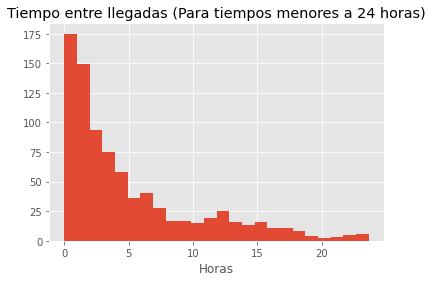

In [62]:
llegadas = df_info_pacientes["Entrada"].sort_values()
tiempo_entre_llegadas = (llegadas.shift(-1) - llegadas)/np.timedelta64(1,"h")
hist = tiempo_entre_llegadas[tiempo_entre_llegadas < 24].hist(bins = 24)
hist.set_xlabel("Horas")
hist.set_title("Tiempo entre llegadas (Para tiempos menores a 24 horas)")

Text(0.5, 0, 'Hora del día')

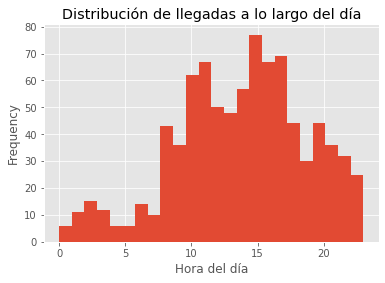

In [63]:
horas_entrada = [entrada.hour for entrada in df_info_pacientes["Entrada"]]
df_info_pacientes["Hora entrada"] = horas_entrada
hist = df_info_pacientes["Hora entrada"].plot.hist(bins = 24,title = "Distribución de llegadas a lo largo del día")
hist.set_xlabel("Hora del día")

# Segundo set  (Operaciones)

In [64]:
print(datos_operaciones["DURACION (hrs)"].mean())
print(datos_operaciones["DURACION (hrs)"].max())
print(datos_operaciones["DURACION (hrs)"].min())

2.4310679611650485
4.1
0.0


Text(0.5, 0, 'Horas')

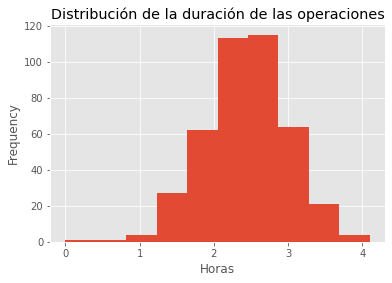

In [65]:
hist = datos_operaciones["DURACION (hrs)"].plot.hist()
hist.set_title("Distribución de la duración de las operaciones")
hist.set_xlabel("Horas")

Text(0.5, 1.0, 'Cantidad de operaciones recibidas por paciente')

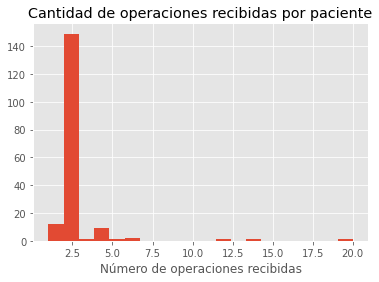

In [66]:
hist = datos_operaciones["ID"].value_counts().hist(bins = 20)
hist.set_xlabel("Número de operaciones recibidas")
hist.set_title("Cantidad de operaciones recibidas por paciente")

Text(0, 0.5, 'Número de operaciones realizadas')

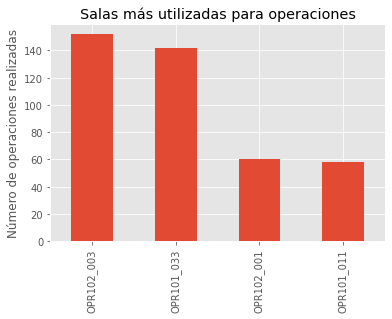

In [67]:
barplot = datos_operaciones["SALA OPERACIONES"].value_counts().plot.bar()
barplot.set_title("Salas más utilizadas para operaciones")
barplot.set_ylabel("Número de operaciones realizadas")

In [68]:
datos_operaciones

,ID,SALA OPERACIONES,FECHA E INICIO,DURACION (hrs)
0,14548704,OPR101_011,2018-01-02 10:15:00.000,2.8
1,14557024,OPR101_011,2017-12-22 13:37:00.000,1.6
2,14557024,OPR101_011,2018-01-12 15:36:00.000,1.2
3,14562339,OPR101_011,2018-01-03 15:56:00.000,1.3
4,14568735,OPR101_011,2018-01-05 18:34:00.000,3.2
...,...,...,...,...
407,14775043000,OPR102_003,2018-03-15 15:17:00.000,2.4
408,14799531000,OPR102_003,2018-03-26 13:02:00.000,3.3
409,14867095000,OPR102_003,2018-04-17 18:25:00.000,3.4
410,14973437000,OPR102_003,2018-05-30 13:42:00.000,2.4


In [69]:
areas_mapa_profe

['URG101_003',
 'DIV101_603',
 'DIV101_604',
 'DIV101_703',
 'DIV102_203',
 'DIV103_107',
 'DIV103_204',
 'DIV104_602',
 'OPR101_011',
 'OPR101_033',
 'OPR102_001',
 'OPR102_003',
 'End']

# Encontramos las distribuciones 

In [70]:
from scipy import stats

In [71]:
dic_distribuciones = dict.fromkeys(areas_mapa_profe)
for area in areas_mapa_profe:
    try : 
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)
        f = Fitter(estadia,distributions = ["expon","beta","lognorm","norm",])
        f.fit()
        best = f.get_best(method = "sumsquare_error")
        dic_distribuciones[area] = best
        print(area,"lista")
    
    except:
        continue
        


URG101_003 lista
DIV101_603 lista
DIV101_604 lista
DIV101_703 lista
DIV102_203 lista
DIV103_107 lista
DIV103_204 lista
DIV104_602 lista
OPR101_011 lista
OPR101_033 lista
OPR102_001 lista


OPR102_003 lista


## Test de bondad 
Recordar que **si el p-value es menor a 0.05 implica que la distribución ajusta de buena manera a los datos**. Si el p-values es mayor a 0.05 significa que no hay información suficiente para justificar que la distribución ajusta de buena manera.

In [72]:
import math
for area in areas_mapa_profe:
    if area != 'End':
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)
        distribucion = list(dic_distribuciones[area].keys())[0]

        if distribucion == 'beta':
            param_a = dic_distribuciones[area]['beta'][0]
            param_b = dic_distribuciones[area]['beta'][1]
            loc = dic_distribuciones[area]['beta'][2]
            scale = dic_distribuciones[area]['beta'][3]
            esperado = (np.random.beta(a=param_a, b=param_b, size=len(estadia)) - loc) / scale

        elif distribucion == 'lognorm':
            s = dic_distribuciones[area]['lognorm'][0]
            loc = dic_distribuciones[area]['lognorm'][1]
            scale = dic_distribuciones[area]['lognorm'][2]
                
            esperado = (np.random.lognormal(mean=math.log(scale), sigma=s, size=len(estadia)) - loc) / scale

        else:
            print('Distribucion desconocida')

        test_bondad = stats.chisquare(f_obs = estadia, f_exp = esperado)
        print(area)
        resultado_test = list(test_bondad)
        print(f'Estadístico:{resultado_test[0]} p-value: {resultado_test[1]} \n')

KeyError: 0

In [ ]:
dic_distribuciones

{'URG101_003': {'beta': (0.9963865319265526,
   7.549140779895584,
   -5.8548793004373246e-30,
   22.24393218386804)},
 'DIV101_603': {'beta': (0.3616704354973971,
   165.16296501053603,
   -7.412371308927781e-26,
   6922.807468149733)},
 'DIV101_604': {'beta': (0.45703588480386004,
   648.4486740488123,
   -8.513612931753873e-29,
   35054.048864844575)},
 'DIV101_703': {'beta': (0.5703786223184792,
   110.83109431271232,
   -1.462673655225481e-28,
   437.32033985936954)},
 'DIV102_203': {'beta': (0.24377071043553353,
   285.52176298361917,
   -1.187635564202615e-26,
   5018.705281761797)},
 'DIV103_107': {'beta': (0.39836402842306595,
   206.40113822847783,
   -1.5712666431312037e-28,
   10158.914732260619)},
 'DIV103_204': {'beta': (0.4888117957179907,
   109.8607935613231,
   -1.5936649681747108e-28,
   5313.91647884571)},
 'DIV104_602': {'beta': (0.15192779271070977,
   194.10258963560304,
   -5.156397043984947e-29,
   8814.947865303959)},
 'OPR101_011': {'beta': (0.580887388605725

In [ ]:
dic_histogramas= {}

{'lognorm': (1.1325392177517544, -0.1631080499945431, 3.01277091110916)}


AttributeError: 'Fitter' object has no attribute 'fitter_param'

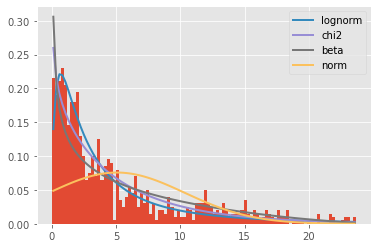

In [ ]:
llegadas = df_info_pacientes["Entrada"].sort_values()
tiempo_entre_llegadas = (llegadas.shift(-1) - llegadas)/np.timedelta64(1,"h")
duracion_operaciones = tiempo_entre_llegadas[tiempo_entre_llegadas < 24]
duracion_operaciones = np.array(duracion_operaciones)
f = Fitter(duracion_operaciones,distributions = ["norm","beta","lognorm","chi2"])
f.fit()
a = f.get_best(method = "sumsquare_error")
print(a)
f.summary()


In [ ]:
dic_histogramas["Tiempo_entre_llegadas"] = a

# Heatmap

In [ ]:
df_heatmap = pd.DataFrame(index = areas_mapa_profe,columns = areas_mapa_profe)

In [ ]:
areas_mapa_profe.append("Outside")

In [ ]:
for area in areas_mapa_profe:
    derivacion_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Siguiente Área"]
    transiciones = (derivacion_urgencia.value_counts()/derivacion_urgencia.shape[0])*100
    df_heatmap[area] = transiciones

In [ ]:
df_heatmap.fillna(0)

In [ ]:
import seaborn as sns
sns.heatmap(df_heatmap.T,annot = True,cmap = "YlOrRd")

# Pacientes por día

In [ ]:
salas_div  = areas_mapa_profe[:-5]


In [ ]:
estadias_div = []
for paciente in set_pacientes :
    info_pacientes = datos_pacientes[datos_pacientes["Case ID"] == paciente]
    info_hospitalizacion = info_pacientes[info_pacientes["Area"].isin(salas_div)]
    estadia = np.sum(info_pacientes["Estadia"])
    estadias_div.append(estadia)
estadia_serie = pd.Series(estadias_div)
estadia_serie = estadia_serie[(estadia_serie >0)]
print("Media de estadia en div (suma)",estadia_serie.mean())

In [ ]:
import datetime

In [ ]:
def convertir_fecha(date):
    fecha = datetime.datetime.strftime(date,"%Y-%m-%d")
    return fecha

In [ ]:
df_info_pacientes["Fecha_entrada"] = [convertir_fecha(df_info_pacientes["Entrada"].iloc[i]) for i in range(df_info_pacientes["Entrada"].shape[0])]

df_info_pacientes

In [ ]:
hist = df_info_pacientes["Fecha_entrada"].value_counts().plot.hist()


In [ ]:
datos_atencion_urg = pd.read_csv("Datos_atencion_urg.csv")
ids_atencion = datos_atencion_urg["ID"]
set_atencion_urg = set(ids_atencion)
for paciente in set_pacientes:
    if paciente not in set_atencion_urg:
        print("Match")

In [ ]:
estadia = datos_pacientes[datos_pacientes["Area"] == "URG101_003"]["Estadia"]
estadia = np.array(estadia)
f = Fitter(estadia,distributions = ["beta"])
f.fit()
hist = f.summary()
plt.set_title("Estadia en URG101_003 distribución ajustada")
plt.set_xlabel("Horas")

In [ ]:
help(Fitter.summary)

## Test de bondad de ajuste